In [92]:
%matplotlib inline
%pylab inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.datasets import make_moons
from IPython.display import clear_output
from IPython import display
from time import sleep
from sklearn.metrics import precision_score, accuracy_score

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [77]:
from pprint import pprint

def softmax(values):
    exp_scores = np.exp(values)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def cross_entropy(model, X, Y, regularization):
    hidden_weights, output_weights = model['HW'], model['OW']
    probs = predict(model, X, get_probs=True)
    
    num_examples = len(Y)
    
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), Y])
    data_loss = np.sum(corect_logprobs)
    
    # Add regulatization term to loss (optional)
    data_loss += (regularization / 2) * (np.sum(np.square(hidden_weights)) + np.sum(np.square(output_weights)))
    
    return 1./num_examples * data_loss

def predict(model, x, get_probs=False):
    hidden_weights, hidden_bias, output_weights, output_bias = model['HW'], model['HB'], model['OW'], model['OB']
    # Forward propagation
    hidden_values = x.dot(hidden_weights) + hidden_bias
    hidden_activations = np.tanh(hidden_values)
    output_values = hidden_activations.dot(output_weights) + output_bias
    
    probs = softmax(output_values)
    if get_probs:
        return probs
    
    return np.argmax(probs, axis=1)

def prediction_contours(model, xx, yy):
    Z = predict(model, np.c_[xx.ravel(), yy.ravel()])
    return Z.reshape(xx.shape)

def extract_data(data):
    X, Y = zip(*data)
    X, Y = np.array(X), np.array(Y)
    return X, Y

def plot(model, ax, X, Y, title):
    preds = predict(model, X)
    precision = precision_score(Y, preds)
    accuracy = accuracy_score(Y, preds)
    ax.set_title("{0} Precision: {1:0.2f}, {0} Accuracy: {2:0.2f}".format(title, precision, accuracy))
    ax.scatter(X[:, 0], X[:, 1], s=60, c=Y, cmap=plt.cm.coolwarm)
    return ax

def build_model(train_data, 
                test_data,
                input_dimensions = 2,
                hidden_dimensions = 3,
                output_dimensions = 2,
                epochs = 1000,
                learning_rate = 0.01,
                regularization = 0.01):
    
    X_train, Y_train = extract_data(train_data)
    X_test, Y_test = extract_data(test_data)
    
    # create a mesh to plot in
    xx_train, yy_train = mesh_grid(X_train)
    xx_test, yy_test = mesh_grid(X_test)
    
    # Define the necessary weights and biases
    hidden_weights = np.random.randn(input_dimensions, hidden_dimensions) / np.sqrt(input_dimensions)
    hidden_bias = np.zeros((1, hidden_dimensions))
    
    output_weights = np.random.randn(hidden_dimensions, output_dimensions) / np.sqrt(hidden_dimensions)
    output_bias = np.zeros((1, output_dimensions))
    
    model = { 
        "HW": hidden_weights,
        "Hb": hidden_bias,
        "OW": output_weights,
        "OB": output_bias
    }
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))
    ax1.scatter(X_train[:, 0], X_train[:, 1], s=60, cmap=plt.cm.coolwarm)
    ax2.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, s=60, cmap=plt.cm.coolwarm)
    
    test_loss = []
    train_loss = []
    for i in range(1, epochs + 1):
        # Forward propagation
        hidden_values = X_train.dot(hidden_weights) + hidden_bias
        hidden_activations = np.tanh(hidden_values)
        output_values = hidden_activations.dot(output_weights) + output_bias
        probs = softmax(output_values)

        # Backpropagation
        output_delta = probs
        output_delta[range(len(X_train)), Y_train] -= 1
        output_weights_delta = (hidden_activations.T).dot(output_delta)
        output_bias_delta = np.sum(output_delta, axis=0, keepdims=True)
        
        hidden_delta = output_delta.dot(output_weights.T) * (1 - np.power(hidden_activations, 2))
        hidden_weights_delta = np.dot(X_train.T, hidden_delta)
        hidden_bias_delta = np.sum(hidden_delta, axis=0)

        # Add regularization terms (the biases don't have regularization terms)
        output_weights_delta += regularization * output_weights
        hidden_weights_delta += regularization * hidden_weights

        # Gradient descent parameter update
        output_weights += -learning_rate * output_weights_delta
        output_bias += -learning_rate * output_bias_delta
        
        hidden_weights += -learning_rate * hidden_weights_delta
        hidden_bias += -learning_rate * hidden_bias_delta
        
        model = { 
            "HW": hidden_weights,
            "HB": hidden_bias,
            "OW": output_weights,
            "OB": output_bias
        }
        
        if i % (epochs / 20) == 0:
            plot(model, ax1, X_train, Y_train, "Train")
            plot(model, ax2, X_test, Y_test, "Test")

            ax1.contourf(xx_train, yy_train, prediction_contours(model, xx_train, yy_train), cmap=plt.cm.coolwarm, alpha=0.3)
            ax2.contourf(xx_test, yy_test, prediction_contours(model, xx_test, yy_test), cmap=plt.cm.coolwarm, alpha=0.3)
            
            ax3.cla()
            ax3.plot(test_loss,  label='Test Error')
            ax3.plot(train_loss, label='Train Error')
            mean_train_loss = np.array(train_loss[-10:]).mean()
            mean_test_loss = np.array(test_loss[-10:]).mean()
            ax3.set_title("Test Loss: {0:0.2f}, Train Loss {1:0.2f}".format(mean_test_loss, mean_train_loss))
            ax3.legend()

            display.clear_output(wait=True)
            display.display(plt.gcf())
        
        test_loss.append(cross_entropy(model, X_test, Y_test, regularization))
        train_loss.append(cross_entropy(model, X_train, Y_train, regularization))

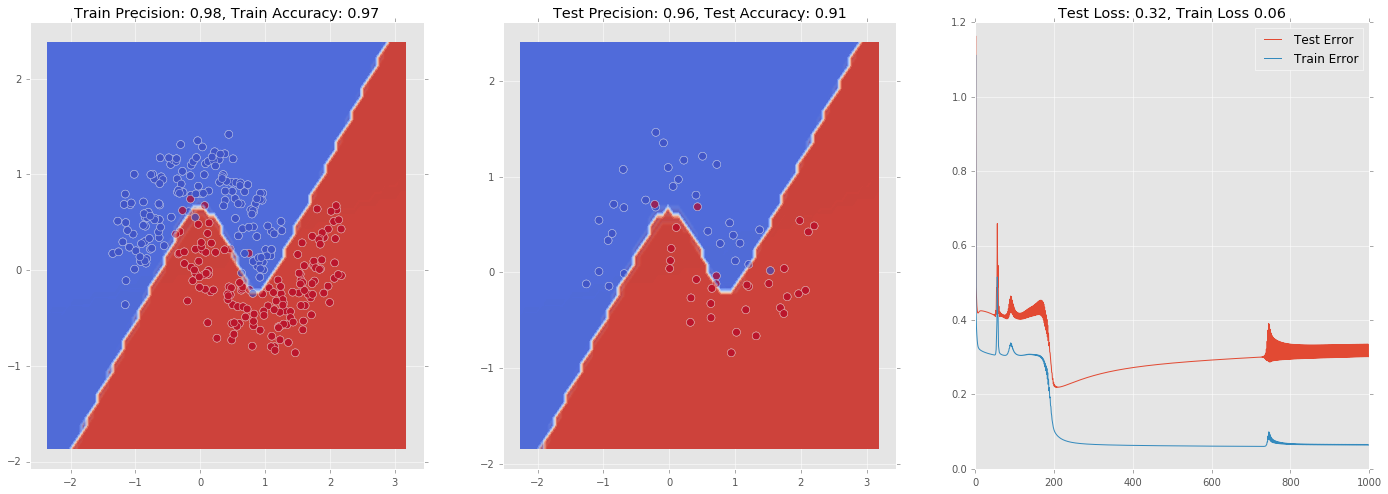

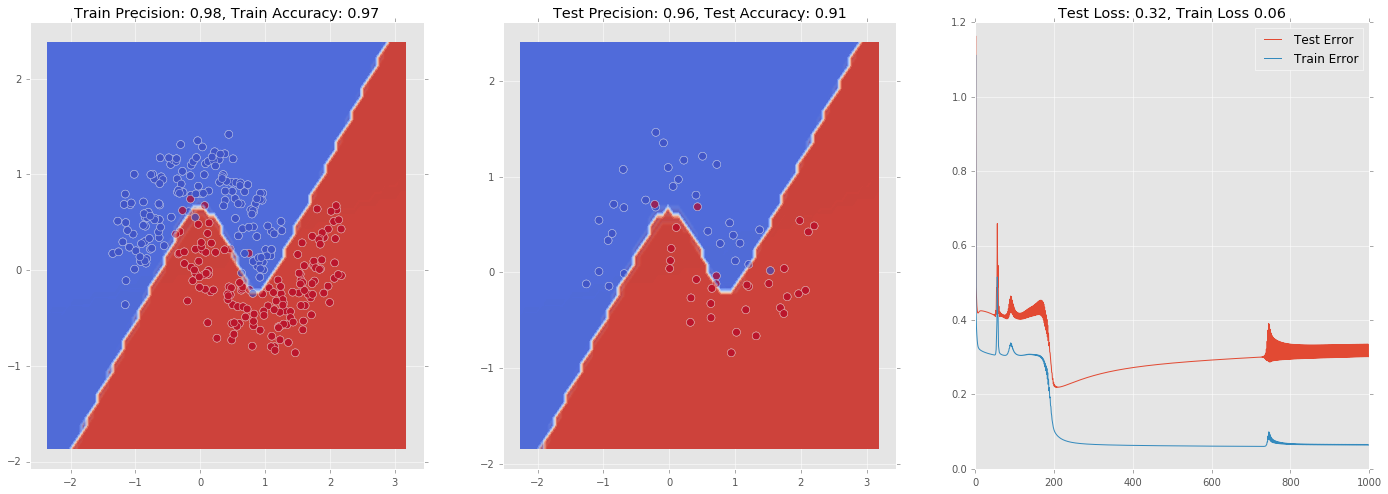

In [78]:
X_train, Y_train = make_moons(300, noise=0.2)
X_test, Y_test = make_moons(60, noise=0.2)


train_data = list(zip(X_train, Y_train))
test_data = list(zip(X_test, Y_test))

build_model(train_data, test_data)